## Description

Produce a plot showing what fraction of the genome is covered at different depths.

In [1]:
import phase3_data

In [2]:
v3 = phase3_data.release_data()

In [3]:
import numba
import numpy as np
import dask.array as da

In [4]:
# kubernetes cluster setup
n_workers = 50
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.scale_up(n_workers)
#cluster.adapt(minimum=1, maximum=n_workers)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.33.239.2:44117
distributed.scheduler - INFO -   dashboard at:                     :8787


In [5]:
# dask client setup
from dask.distributed import Client, progress
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-a4c711de-a678-11ea-8229-b21081f88d10
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.33.239.2:44117 Dashboard: /user/nicholasharding/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
values = 30, 20, 10, 5, 1

In [7]:
all_meta = v3.load_metadata_by_sampleset(v3.all_samplesets)

distributed.scheduler - INFO - Register tcp://10.33.245.4:39601
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.245.4:39601
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.34.11.4:36443
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.11.4:36443
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.240.4:44755
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.240.4:44755
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.253.4:43557
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.253.4:43557
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.251.3:41051
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.251.3:41051
distributed.cor

In [8]:
@numba.njit
def val_sum(block):
    
    values = np.array([30, 20, 10, 5, 1], dtype=np.int32)
    out = np.zeros((block.shape[1], 5), dtype=np.int32)
    
    for i in range(block.shape[0]):
        for j in range(block.shape[1]):
            if block[i, j] >= values[0]:
                out[j, 0] += 1
            elif block[i, j] >= values[1]:
                out[j, 1] += 1
            elif block[i, j] >= values[2]:
                out[j, 2] += 1
            elif block[i, j] >= values[3]:
                out[j, 3] += 1
            elif block[i, j] >= values[4]:
                out[j, 4] += 1
    
 #   return out

    return out.reshape((1, block.shape[1], 5))

In [9]:
chromosomes = "2L", "2R", "3L", "3R", "X"

In [10]:
def compute_coverage_bases(selected_samples, seq_ids=chromosomes):

    result = np.empty(
        (len(seq_ids),            # n contigs
         selected_samples.sum(),  # n samples
         5))                      # n values

    for ix, chrom in enumerate(seq_ids):

        dp = v3.load_calldata_by_sampleset(chrom, v3.all_samplesets, field="AD").sum(axis=2)
        print(f"processing {chrom}")

        # remove males and arabiensis.
        dp_sel = da.compress(selected_samples.values, dp, axis=1)

        r = da.map_blocks(
            val_sum, 
            dp_sel,
            dtype=np.int32, 
            chunks=(1, dp_sel.chunks[1], 5), 
            new_axis=(2,))

        co = r.compute()

        result[ix] = co.sum(axis=0).cumsum(axis=1)
        
    contig_sizes = np.array([v3.load_mask(sid, "gamb_colu").shape[0] for sid in seq_ids])
        
    all_chroms_norm = result.sum(0) / contig_sizes.sum()
    
    assert all_chroms_norm.max() <= 1.0, "bug, fraction can never exceed 1.0"
                
    return all_chroms_norm, result

In [11]:
sel_samples_gambcolu_f = all_meta.is_gamb_colu & (all_meta.sex_call == 'F')
sel_samples_arab_f = all_meta.is_arabiensis & (all_meta.sex_call == 'F')

In [12]:
r = {}

for label, sel in zip(["gamb_colu", "arabiensis"], [sel_samples_gambcolu_f, sel_samples_arab_f]):
    normed_r, _ = compute_coverage_bases(sel)
    r[label] = np.percentile(normed_r, [1, 5, 50, 95, 99], axis=0)

processing 2L


distributed.core - INFO - Event loop was unresponsive in Scheduler for 19.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


processing 2R


distributed.core - INFO - Event loop was unresponsive in Scheduler for 24.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.scheduler - INFO - Register tcp://10.34.39.2:44467
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.39.2:44467
distributed.core - INFO - Starting established connection


processing 3L


distributed.core - INFO - Event loop was unresponsive in Scheduler for 17.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


processing 3R


distributed.core - INFO - Event loop was unresponsive in Scheduler for 22.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


processing X


distributed.core - INFO - Event loop was unresponsive in Scheduler for 10.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


processing 2L
processing 2R


distributed.core - INFO - Event loop was unresponsive in Scheduler for 6.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


processing 3L
processing 3R


distributed.core - INFO - Event loop was unresponsive in Scheduler for 6.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


processing X


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

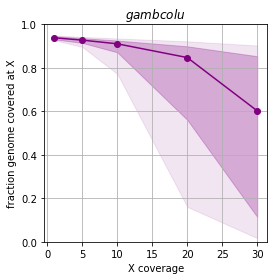

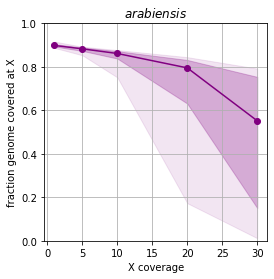

In [14]:
for key, percentiles in r.items():

    fig, ax = plt.subplots(figsize=(4, 4))

    plot_col = "purple"

    ax.plot(values, percentiles[2], '-o', color=plot_col)
    ax.fill_between(values, percentiles[0], percentiles[-1], alpha=0.1, color=plot_col)
    ax.fill_between(values, percentiles[1], percentiles[-2], alpha=0.25, color=plot_col)
    ax.grid(True)
    ax.set_ylabel("fraction genome covered at X")
    ax.set_xlabel("X coverage")
    ax.set_ylim((0, 1.0))
    ax.set_title(f"${key.replace('_', ' ')}$")

    fig.savefig(f"../content/images/{key}_frac_covered_X.svg")

In [15]:
sel_samples_gambcolu_f.sum(), sel_samples_arab_f.sum()

(2166, 365)

### Caption

Fig X. Plot showing the median fraction of genome covered by at least X reads, where X is the value on the X axis. As well as median- the 5/95 and 1/99 percentiles are displayed as filled ranges. Only female samples are shown, allowing inclusion of the X chromosome, in A) A. gambiae and coluzzii (n=2166), and B) arabiensis (n=365). 

In [16]:
cluster.adapt()

distributed.scheduler - INFO - Retire worker names (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49)
distributed.deploy.adaptive - INFO - Retiring workers [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
distributed.scheduler - INFO - Remove worker tcp://10.33.248.4:41695
distributed.core - INFO - Removing comms to tcp://10.33.248.4:41695
distributed.scheduler - INFO - Remove worker tcp://10.34.10.4:38885
distributed.core - INFO - Removing comms to tcp://10.34.10.4:38885
distributed.scheduler - INFO - Remove worker tcp://10.34.14.4:46563
distributed.core - INFO - Removing comms to tcp://10.34.14.4:46563
distributed.scheduler - INFO - Remove worker tcp://10.34.12.4:46589
distributed.core - INFO - Removing com